In [1]:
import numpy as np
import pandas as pd
import os
import calendar
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta
from tqdm import tqdm
pd.options.display.max_columns =100
%matplotlib inline

In [20]:
def readAllCSV():

  month_mapping = {month: index for index, month in enumerate(calendar.month_name) if month}

  file_list = os.listdir('data')

  file_list = sorted(file_list, key=lambda x: month_mapping.get(x.split('.')[0]))
  dfs = []
  for file_name in file_list:
      
      file_path = os.path.join('data', file_name)
      df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
      dfs.append(df)
  return dfs

def extractUsefulInfo(table, columns):

  df = table[columns]
  df = df.drop(df.index[0])
  df[columns[:-1]] = df[columns[:-1]].astype(float)  
  df['date'] = pd.to_datetime(df['date'].astype('datetime64[s]'))
  #df['date'] = df['date'].apply(lambda x: x.timestamp())

  print("Printing NaN's")
  print(df.isna().sum())
  df.dropna(inplace=True)
  df = df[df['mill_operation'].apply(lambda x: x != 0)]

  return df


def plots(df,column,q_low,q_hi):

  low_threshold = df[column].quantile(q_low)
  high_threshold = df[column].quantile(q_hi)

  filtered_data = df[
      (df[column] >= low_threshold) &
      (df[column] <= high_threshold)
  ]

  plt.plot(filtered_data['date'], filtered_data[column])
  plt.xlabel('Date')
  plt.ylabel(column)
  plt.title('Visualization of ' + column + ' (Filtered)')

  num_ticks = 10

  step = len(filtered_data) // num_ticks


  x_ticks = filtered_data['date'][::step]

  plt.xticks(x_ticks, rotation=90)

  plt.show()


In [3]:
df_list = readAllCSV()
june = df_list[1]

<ipython-input-2-67e124f914f8>:12: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
<ipython-input-2-67e124f914f8>:12: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
<ipython-input-2-67e124f914f8>:12: DtypeWarning: Columns (

In [4]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv','mill_operation','date']

june_first = extractUsefulInfo(june,columns)
print(june_first.shape)

Printing NaN's
separator_speed_rpm_pv    10
mill_dp_mbar_pv           14
separator_pwr_kw_pv       14
mill_operation            14
date                       0
dtype: int64
(45396, 5)


In [5]:
june_first

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,mill_operation,date
6496,527.44,30.94,57.40,1.0,2019-03-06 06:07:00
6497,526.54,32.35,56.61,1.0,2019-03-06 06:08:00
6498,527.60,34.50,55.70,1.0,2019-03-06 06:08:00
6499,700.51,35.06,56.36,1.0,2019-03-06 06:09:00
6500,697.55,35.11,56.93,1.0,2019-03-06 06:09:00
...,...,...,...,...,...
77144,716.51,33.61,56.23,1.0,2019-06-30 23:58:00
77145,718.73,33.59,55.48,1.0,2019-06-30 23:58:00
77146,723.00,33.60,59.70,1.0,2019-06-30 23:58:00
77147,733.20,33.72,56.12,1.0,2019-06-30 23:59:00


In [6]:
june_first['date'] = pd.to_datetime(june_first['date'].astype('datetime64[s]'))


In [7]:
june_first

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,mill_operation,date
6496,527.44,30.94,57.40,1.0,2019-03-06 06:07:00
6497,526.54,32.35,56.61,1.0,2019-03-06 06:08:00
6498,527.60,34.50,55.70,1.0,2019-03-06 06:08:00
6499,700.51,35.06,56.36,1.0,2019-03-06 06:09:00
6500,697.55,35.11,56.93,1.0,2019-03-06 06:09:00
...,...,...,...,...,...
77144,716.51,33.61,56.23,1.0,2019-06-30 23:58:00
77145,718.73,33.59,55.48,1.0,2019-06-30 23:58:00
77146,723.00,33.60,59.70,1.0,2019-06-30 23:58:00
77147,733.20,33.72,56.12,1.0,2019-06-30 23:59:00


In [8]:
june_first

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,mill_operation,date
6496,527.44,30.94,57.40,1.0,2019-03-06 06:07:00
6497,526.54,32.35,56.61,1.0,2019-03-06 06:08:00
6498,527.60,34.50,55.70,1.0,2019-03-06 06:08:00
6499,700.51,35.06,56.36,1.0,2019-03-06 06:09:00
6500,697.55,35.11,56.93,1.0,2019-03-06 06:09:00
...,...,...,...,...,...
77144,716.51,33.61,56.23,1.0,2019-06-30 23:58:00
77145,718.73,33.59,55.48,1.0,2019-06-30 23:58:00
77146,723.00,33.60,59.70,1.0,2019-06-30 23:58:00
77147,733.20,33.72,56.12,1.0,2019-06-30 23:59:00


In [9]:
june

,Unnamed: 0,_id,date,total_feed_perc_pv,clinker_perc_pv,limestone_perc_pv,slag_perc_pv,gypsum_perc_pv,pozzolane_perc_pv,fly_ash_1_perc_pv,fly_ash_2_perc_pv,clinker_perc_sp,limestone_perc_sp,slag_perc_sp,gypsum_perc_sp,pozzolane_perc_sp,fly_ash_1_perc_sp,fly_ash_2_perc_sp,total_feed_ton/h_pv,clinker_ton/h_pv,limestone_ton/h_pv,slag_ton/h_pv,gypsum_ton/h_pv,pozzolane_ton/h_pv,fly_ash_1_ton/h_pv,fly_ash_2_ton/h_pv,total_feed_ton/h_sp,slag_ton/h_sp,limestone_ton/h_sp,clinker_ton/h_sp,pozzolane_ton/h_sp,gypsum_ton/h_sp,fly_ash_1_ton/h_sp,fly_ash_2_ton/h_sp,mill_injection_water_perc_sp,mill_motor_pwr_kw_pv,recirculation_damper_perc_pv,recirculation_damper_perc_sp,fresh_air_damper_perc_pv,fresh_air_damper_perc_sp,main_fan_pwr_kw_pv,main_fan_speed_rpm_pv,main_bf_out_press_mbar_pv,main_bf_dp_mbar_pv,grinding_pressure_bar_sp,grinding_pressure_bar_pv,bucket_elv_mtr_pwr_kw_pv,mill_in_pres_mbar_pv,mill_in_pres_mbar_sp,mill_in_temp_c_pv,mill_exit_temp_c_pv,mill_dp_mbar_pv,mill_out_pres_mbar_pv,separator_speed_perc_sp,separator_pwr_kw_pv,separator_speed_rpm_pv,icon_bed_temp_c_sp,icon_bed_temp_c_pv,icon_ceiling_temp_c_pv,icon_exit_temp_c_pv,mill_injection_water_m3/h_pv,roller_1_bed_depth_mm_pv,roller_2_bed_depth_mm_pv,roller_3_bed_depth_mm_pv,mill_vibration_mm/s_pv,gearbox_1_vibration_mm/s_pv,gearbox_2_vibration_mm/s_pv,hopper_level_mg/m3_pv,thrust_pad_1_press_bar_pv,thrust_pad_2_press_bar_pv,thrust_pad_3_press_bar_pv,thrust_pad_4_press_bar_pv,thrust_pad_5_press_bar_pv,thrust_pad_6_press_bar_pv,thrust_pad_7_press_bar_pv,thrust_pad_8_press_bar_pv,thrust_pad_9_press_bar_pv,thrust_pad_10_press_bar_pv,thrust_pad_11_press_bar_pv,thrust_pad_12_press_bar_pv,grinding_aid_addition_l/h_pv,grinding_aid_addition_perc_sp,blaine_cm3/g_pv,so3_perc_pv,fineness_perc_pv,moisture_slag_perc_pv,moisture_pozzolane_perc_pv,moisture_clinker_perc_pv,moisture_limestone_perc_pv,moisture_gypsum_perc_pv,moisture_fly_ash_1_perc_pv,moisture_fly_ash_2_perc_pv,time_sample_taken_cpii_pv,cement_type_cpii_bool_pv,cement_type_cpiv_bool_pv,mill_operation
0,NaN,NaN,NaN,NaN,CLINKER WF(%) PV,LIMESTONE WF(%) PV,SLAG WF(%) PV,GYPSUM WF(%) PV,POZZOLANE WF(%) PV,FLY ASH1 (%) PV,FLY ASH2 (%) PV,CLINKER WF(%) SP,LIMESTONE WF(%) SP,SLAG WF(%) SP,GYPSUM WF(%) SP,POZZOLANE WF(%) SP,FLY ASH1 (%) SP,FLY ASH2 (%) SP,TOTAL FEED (ton/h) PV,CLINKER WF (ton/h),LIMESTONE WF (ton/h),SLAG WF (ton/h),GYPSUM WF (ton/h),POZZOLANE WF (ton/h),FLY ASH1 (ton/h),FLY ASH2 (ton/h),TOTAL FEED (ton/h) SP,SLAG WF(ton/h) SP,LIMESTONE WF(ton/h)SP,CLINKER WF (ton/h) SP,POZZOLANE WF(ton/h) SP,GYPSUM WF(ton/h) SP,FLY ASH 1(ton/h) SP,FLY ASH 2(ton/h) SP,CEMENT MILL TABLE WATER SPRAY(%) SP,MILL MOTOR POWER (KW),RECIRCULATION DAMPER PV (%),RECIRCULATION DAMPER SP (%),FRESH AIR DAMPER PV (%),FRESH AIR DAMPER SP (%),MAIN FAN POWER (KW),NaN,MAIN BF OUT PRESS (mbar),CEMENT MILL BF DP(mbar),GRINDING PRESSURE(bar) SP,GRINDING PRESSURE(bar) PV,BUCKET ELV MTR POWER (KW),MILL IN PRES (mbar) PV,MILL IN PRES (mbar) SP,MILL IN TEMP (°C),MILL EXIT TEMP (°C),CEMENT MILL DP (mbar),MILL OUT PRES (mbar),SET POINT SEPARATOR SPEED(%),SEPARATOR POWER (KW),SEPARATOR SPEED (RPM) PV,ICON BED TEMP(°C) SP,ICON BED TEMP (°C),ICON CEILING TEMP (°C),ICON EXIT (°C),CEMENT MILL TABLE WATER SPRAY(m³/h) PV,ROLLER 1 BED DEPTH (mm),ROLLER 2 BED DEPTH (mm),ROLLER 3 BED DEPTH (mm),MILL VIBRATION (mm/s),GEARBOX ACCEREROMETER 1 VIBRATION (mm/s),GEARBOX ACCEREROMETER 2 VIBRATION (mm/s),HOPPER LEVEL INDICATOR (mg/m³),THRUST PAD 1 OIL PRESS (bar),THRUST PAD 2 OIL PRESS (bar),THRUST PAD 3 OIL PRESS (bar),THRUST PAD 4 OIL PRESS (bar),THRUST PAD 5 OIL PRESS (bar),THRUST PAD 6 OIL PRESS (bar),THRUST PAD 7 OIL PRESS (bar),THRUST PAD 8 OIL PRESS (bar),THRUST PAD 9 OIL PRESS (bar),THRUST PAD 10 OIL PRESS (bar),THRUST PAD 11 OIL PRESS (bar),THRUST PAD 12 OIL PRESS (bar),GRINDING AID ADDITION PV,GRINDING AID ADDITION SP,BLAINE,SO3,FINENESS,Moisture SLAG,Moisture POZZOLANE,Moisture CLINKER,Moisture LIMESTONE,Moisture GYPSUM,Moisture FLYASH 1,Moisture FLY ASH 2,Time Sample

In [10]:
july = df_list[2]
july_first = extractUsefulInfo(july,columns)
july_first

Printing NaN's
separator_speed_rpm_pv    2
mill_dp_mbar_pv           1
separator_pwr_kw_pv       1
mill_operation            2
date                      0
dtype: int64


,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,mill_operation,date
1,737.74,33.46,56.12,1.0,2019-07-01 00:00:00
2,726.38,33.74,71.28,1.0,2019-07-01 00:00:00
3,666.81,33.03,56.10,1.0,2019-07-01 00:00:30
4,666.86,33.52,55.50,1.0,2019-07-01 00:00:30
5,664.65,33.17,55.47,1.0,2019-07-01 00:01:00
...,...,...,...,...,...
73165,700.24,33.77,56.19,1.0,2019-07-31 23:57:00
73166,700.19,33.81,56.56,1.0,2019-07-31 23:57:00
73167,700.03,33.51,56.35,1.0,2019-07-31 23:58:00
73168,702.41,33.53,56.37,1.0,2019-07-31 23:58:00


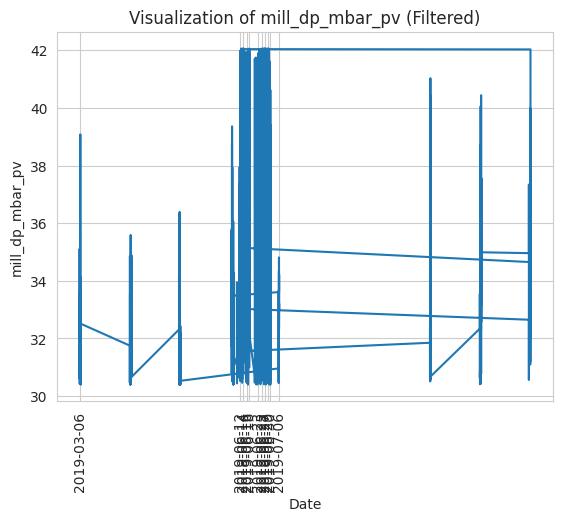

In [21]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'mill_dp_mbar_pv',q_low,q_hi)


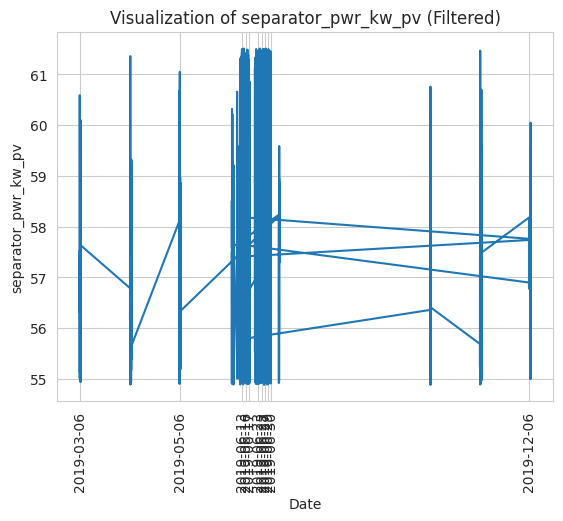

In [22]:
q_low = 0.01
q_hi = 0.99
plots(june_first,'separator_pwr_kw_pv',q_low,q_hi)

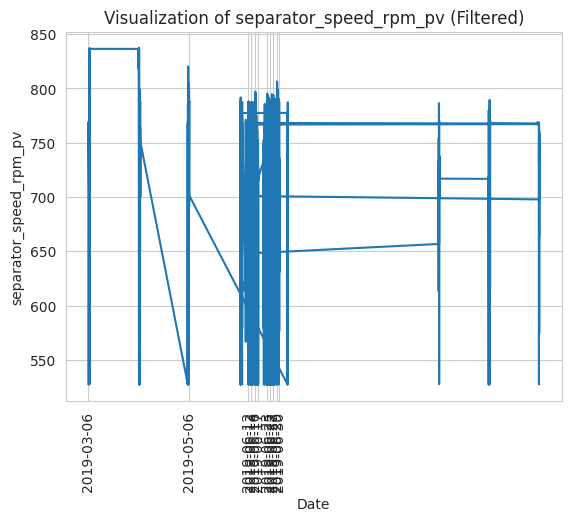

In [23]:
q_low = 0.01
q_hi = 0.99
plots(june_first,'separator_speed_rpm_pv',q_low,q_hi)

In [14]:
# Normalize data
sc = StandardScaler()
X = june_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y = june_first['separator_speed_rpm_pv']
X_test = july_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y_test =  july_first['separator_speed_rpm_pv']

X = sc.fit_transform(X)
X_test= sc.transform(X_test)


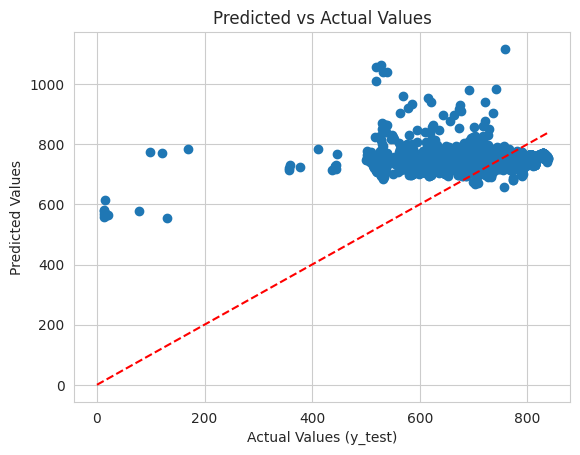

In [15]:
# Linear Regression
model = LinearRegression()


model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [31]:
lag_steps = 20
feature_cols = ['mill_dp_mbar_pv', 'separator_pwr_kw_pv']
# Create lag features for the target column
for i in range(1, lag_steps + 1):
    june_first[f'separator_speed_rpm_pv_lag{i}'] = june_first['separator_speed_rpm_pv'].shift(i)

# Create lag features for the feature columns
for feature_col in ['mill_dp_mbar_pv', 'separator_pwr_kw_pv']:
    for i in range(1, lag_steps + 1):
        june_first[f'{feature_col}_lag{i}'] = june_first[feature_col].shift(i)
june_first.dropna(inplace=True)
X = june_first[feature_cols + [f'{col}_lag{i}' for i in range(1, lag_steps + 1) for col in ['separator_speed_rpm_pv'] + feature_cols]]
y = june_first['separator_speed_rpm_pv']
# Calculate the index to split the data
split_index = int(len(june_first) * 0.8)

# Split the data into training and testing sets
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]
# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) as a performance metric
rmse = mean_squared_error(y_test, y_pred, squared=False)

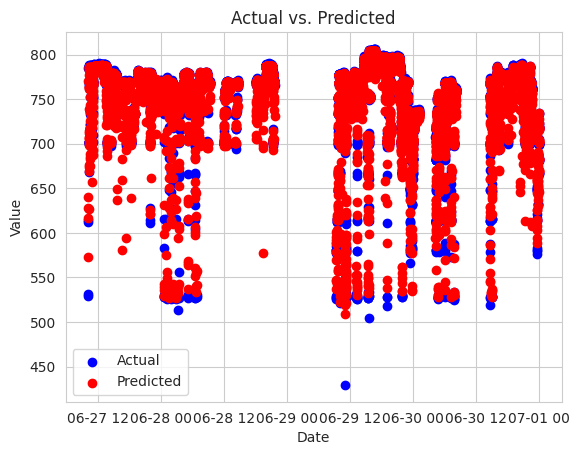

In [33]:
# Plot the actual values as scatter points
plt.scatter(june_first.loc[X_test.index, 'date'], y_test, label='Actual', color='blue')

# Plot the predicted values as scatter points
plt.scatter(june_first.loc[X_test.index, 'date'], y_pred, label='Predicted', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [35]:
from sklearn.metrics import r2_score

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared score: {r2}')

R-squared score: 0.8759073566693678


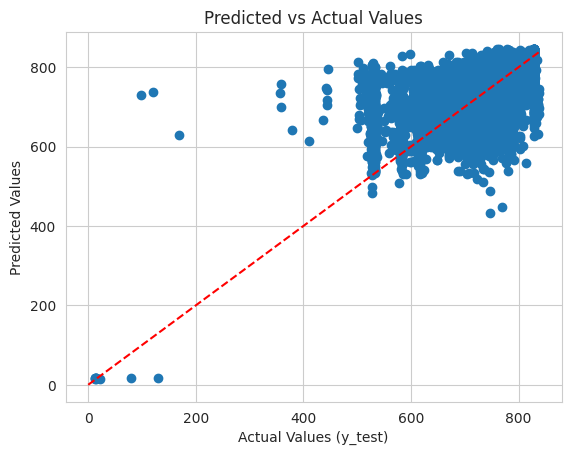

In [16]:
# RandomForest Regressor

# My max_depth=16
param_grid = {
    'n_estimators' : [10, 50, 100, 200, 1000],
    'criterion' : ['squared_error','absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [None, 4, 8, 12],
    'min_samples_split' : [2, 5, 8]
}
model = RandomForestRegressor()

gs = GridSearchCV(model,param_grid,scoring='neg_mean_squared_error',verbose=10,n_jobs =-1)
#gs.fit(X,y)
model.fit(X, y)
# Define the number of lag steps

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [17]:
# IGNORE einai gia to deutero, apla evlepa.

columns = ['total_feed_ton/h_pv', 'fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv',
           'main_fan_speed_rpm_pv', 'separator_speed_rpm_pv', 'grinding_pressure_bar_pv',
           'mill_injection_water_m3/h_pv', 'bucket_elv_mtr_pwr_kw_pv', 'mill_dp_mbar_pv','mill_operation','date']

second = extractUsefulInfo(june,columns)

Printing NaN's
total_feed_ton/h_pv             12
fly_ash_1_ton/h_pv              11
fly_ash_2_ton/h_pv              16
main_fan_speed_rpm_pv           19
separator_speed_rpm_pv          10
grinding_pressure_bar_pv        13
mill_injection_water_m3/h_pv    25
bucket_elv_mtr_pwr_kw_pv        12
mill_dp_mbar_pv                 14
mill_operation                  14
date                             0
dtype: int64


In [18]:
june_first

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,mill_operation,date
6496,527.44,30.94,57.40,1.0,2019-03-06 06:07:00
6497,526.54,32.35,56.61,1.0,2019-03-06 06:08:00
6498,527.60,34.50,55.70,1.0,2019-03-06 06:08:00
6499,700.51,35.06,56.36,1.0,2019-03-06 06:09:00
6500,697.55,35.11,56.93,1.0,2019-03-06 06:09:00
...,...,...,...,...,...
77144,716.51,33.61,56.23,1.0,2019-06-30 23:58:00
77145,718.73,33.59,55.48,1.0,2019-06-30 23:58:00
77146,723.00,33.60,59.70,1.0,2019-06-30 23:58:00
77147,733.20,33.72,56.12,1.0,2019-06-30 23:59:00
